# Data Loading and Processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install noisereduce
!pip install librosa

In [ ]:
import librosa
import os
import noisereduce as nr
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from collections import defaultdict
import soundfile as sf
from tqdm import tqdm

In [ ]:
def is_overlap(cstart_time, cend_time, start_time, end_time):
  if(cstart_time > end_time):
    return False
  if(cend_time < start_time):
    return False
  if(start_time > cstart_time and end_time < cend_time ):
    return True
  if(start_time > cstart_time):
    overlap = start_time - cstart_time
    if(overlap > 0.50 * (start_time - cend_time)):
      return True
    else:
      return False
  if(end_time < cend_time):
    overlap = cend_time - end_time
    if(overlap > 0.50 * (start_time - cend_time)):
      return True
    else:
      return False
  
  return True

def one_hot_enc(cl_name):
  if(cl_name == 'music'):
    return np.array([0,1,0])
  elif(cl_name == 'speech'):
    return np.array([1,0,0])
  else:
    return np.array([0,0,1])


def load_audio(filename, cls, Fs = 16000):
    # Return bins of size of 1000 corresponding to 
    x, _ = librosa.load(filename, sr=Fs)
    x = nr.reduce_noise(x, Fs)
    x = np.reshape(x[:K], (-1,SPLIT_SIZE))
    labels = np.zeros((N,3))
    for index, sub_audios in enumerate(x):
      class_assigned = False
      for tup in enumerate(cls):
        if(is_overlap(tup[1][0], tup[1][1], index*SPLIT_SIZE/K, (index+1)*SPLIT_SIZE/K)):
          labels[index] = one_hot_enc(tup[1][2])
          class_assigned = True
          break
      if(class_assigned == False):
          labels[index] = one_hot_enc('silence')
    
    return labels, x


def load_data(foldername, Fs=16000):
  '''
  Inputs: 
      foldername: (str) foldername
      Fs: (int) sampling rate
  
  Output:
      data: np array of data
  '''

  files = os.listdir(foldername+'/wav')
  df = pd.read_csv (foldername+'/labels.csv', usecols=['filename','onset','offset','class'])
  print(df.head())
  labels_data = df.to_numpy()
  data = dict()
  labels = defaultdict(list)
  
  for entry in labels_data:
    # print(entry[0])
    # print((entry[1],entry[2],entry[3]))
    labels[entry[0]].append((entry[1],entry[2],entry[3]))
  
  labels_list = []
  data_list = []

  for wav_file in tqdm(files):
    ls, audio = load_audio(foldername+"/wav/"+wav_file, labels[wav_file[:-4]], Fs)
    labels_list.append(ls)
    data_list.append(audio)

  labels_final = np.array(labels_list)
  data_final = np.array(data_list)
  labels_final = labels_final.reshape(N*len(files), 3)
  data_final = data_final.reshape(N*len(files), SPLIT_SIZE)
  # print(labels_final.shape)
  # print(data_final.shape)
  return labels_final, data_final


def reverse_one_hot(ohv):
  if(ohv[1] == 1):
    return "music"
  elif(ohv[0] == 1):
    return "speech"
  else:
    return "silence"

def save_data(train_labels, train_audios):
  for i in range(len(train_audios)):
    print(reverse_one_hot(train_labels[i]))
    sf.write('/content/drive/MyDrive/Sem 5/EE603/project/val_set/split_wavs/'+str(i)+'.wav', train_audios[i], 16000)

def get_mfcc(train_audios, n_mfcc=20, Fs=16000):
    mfccs=[]
    for audio in tqdm(train_audios):
      mfccs.append(librosa.feature.mfcc(audio, n_mfcc=n_mfcc, sr=Fs, n_fft=512))
      # mfccs.append(audio_mfcc)
    mfccs = np.array(mfccs)
    return mfccs

In [ ]:
SAMPLING_RATE = 16000
AUDIO_DURATION = 10 #in seconds
FRAME_ACCURACY = 0.99
SPLIT_SIZE = 1000
MAX_SAMPLES = 0
K = int(AUDIO_DURATION*SAMPLING_RATE*FRAME_ACCURACY/SPLIT_SIZE)*SPLIT_SIZE
N = int(K/SPLIT_SIZE)

In [ ]:
train_labels, train_audios = load_data('/content/drive/MyDrive/Sem 5/EE603/project/val_set')

  filename   onset  offset   class
0     S001  0.7545   1.963  speech
1     S001  3.0330   4.365  speech
2     S001  5.2850   6.591  speech
3     S001  7.6340   9.019  speech
4     S002  0.1580   1.060  speech


100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


In [ ]:
print(np.shape(train_labels), type(train_labels))
print(np.shape(train_audios), type(train_audios))

(4740, 3) <class 'numpy.ndarray'>
(4740, 1000) <class 'numpy.ndarray'>


In [ ]:
train_audios_mfcc = get_mfcc(train_audios=train_audios, n_mfcc=20, Fs = SAMPLING_RATE)

print(np.shape(train_audios_mfcc), type(train_audios_mfcc))

100%|██████████| 4740/4740 [00:10<00:00, 459.11it/s]

(4740, 20, 2) <class 'numpy.ndarray'>


# Template Matching

In [ ]:
Y_num = []

for label in tqdm(train_labels):
  if label[1] == 1:
    Y_num.append(2) #music
  elif label[0] == 1:
    Y_num.append(1) #speech
  else:
    Y_num.append(0) #silence

X = np.reshape(train_audios_mfcc, (train_audios_mfcc.shape[0], -1))
st = StandardScaler()
X = st.fit_transform(X)

Y = Y_num
print(np.shape(X), np.shape(Y))
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

100%|██████████| 4740/4740 [00:00<00:00, 579840.78it/s]

(4740, 40) (4740,)
(3792, 40) (948, 40) (3792,) (948,)


In [ ]:
# we'll use first 100 data items of every label, each as the templates
N = 100

templates = np.zeros((3, N, X_train[0].shape[0]))
counts = [0,0,0]

for i in tqdm(range(len(y_train))):
  if counts == [N, N, N]:
    break
  if counts[y_train[i]] < 100:
    templates[y_train[i], counts[y_train[i]]] = X_train[i]
    counts[y_train[i]] += 1

print(np.shape(templates))

 31%|███       | 1167/3792 [00:00<00:00, 258995.33it/s]

(3, 100, 40)


In [ ]:
y_train_pred = np.zeros(len(X_train))
y_test_pred = np.zeros(len(X_test))

for i in tqdm(range(len(X_test))):
  scores = [0,0,0]
  for j in range(3):
    for k in range(N):
      scores[j] += np.linalg.norm(X_test[i]-templates[j][k])
  y_test_pred[i] = np.argmin(scores)


for i in tqdm(range(len(X_train))):
  scores = [0,0,0]
  for j in range(3):
    for k in range(N):
      scores[j] += np.linalg.norm(X_train[i]-templates[j][k])
  y_train_pred[i] = np.argmin(scores)

100%|██████████| 3792/3792 [00:09<00:00, 379.99it/s]


In [ ]:
train_accuracy = np.mean(y_train_pred.ravel() == np.asarray(y_train).ravel()) * 100
print('Train accuracy:', train_accuracy)
test_accuracy = np.mean(y_test_pred.ravel() == np.asarray(y_test).ravel()) * 100
print('Test accuracy:', test_accuracy)

Train accuracy: 19.62025316455696
Test accuracy: 19.09282700421941


In [ ]:
from collections import Counter
print(Counter(y_train_pred), Counter(y_train))
print(Counter(y_test_pred), Counter(y_test))

Counter({1.0: 3288, 0.0: 468, 2.0: 36}) Counter({0: 2957, 2: 491, 1: 344})
Counter({1.0: 816, 0.0: 117, 2.0: 15}) Counter({0: 752, 2: 116, 1: 80})


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [ ]:
Y_num = []

for label in tqdm(train_labels):
  if label[1] == 1:
    Y_num.append(2) #music
  elif label[0] == 1:
    Y_num.append(1) #speech
  else:
    Y_num.append(0) #silence

X = np.reshape(train_audios_mfcc, (train_audios_mfcc.shape[0], -1))
st = StandardScaler()
X = st.fit_transform(X)

Y = Y_num
print(np.shape(X), np.shape(Y))
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7985232067510548

# DNN

In [ ]:
X = np.reshape(train_audios_mfcc, (train_audios_mfcc.shape[0], -1))
st = StandardScaler()
X = st.fit_transform(X)

Y = train_labels
print(np.shape(X), np.shape(Y))
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(4740, 40) (4740, 3)
(3792, 40) (948, 40) (3792, 3) (948, 3)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 128,
    'output_dim': y_train.shape[1],
    'epochs': 50,
    'batch_size': 512,
    'verbose': 1,
    'validation_data': (X_test, y_test),
    'shuffle': True
}
clf = KerasClassifier(**model_params)
hist = clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

Epoch 1/50
8/8 [==============================] - 1s 30ms/step - loss: 0.8750 - accuracy: 0.6857 - val_loss: 0.7201 - val_accuracy: 0.7932
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.7555 - accuracy: 0.7795 - val_loss: 0.6776 - val_accuracy: 0.7932
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.7027 - accuracy: 0.7780 - val_loss: 0.6532 - val_accuracy: 0.7911
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6797 - accuracy: 0.7777 - val_loss: 0.6341 - val_accuracy: 0.7922
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6687 - accuracy: 0.7806 - val_loss: 0.6259 - val_accuracy: 0.7932
Epoch 6/50
8/8 [==============================] - 0s 8ms/step - loss: 0.6581 - accuracy: 0.7816 - val_loss: 0.6202 - val_accuracy: 0.7922
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 0.6503 - accuracy: 0.7811 - val_loss: 0.6150 - val_accuracy: 0.7975
Epoch 8/50
8/8 [================

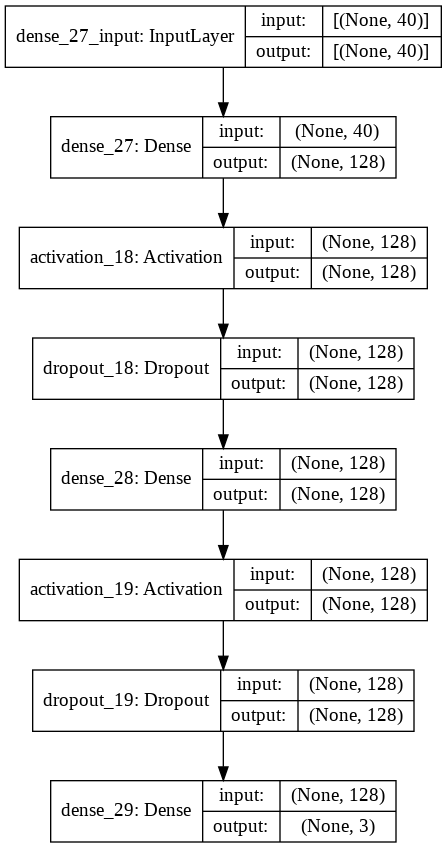

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(clf.model, to_file='model.png', show_shapes=True)

In [ ]:
import matplotlib.pyplot as plt
def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, ax1 = plt.subplots(1, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')

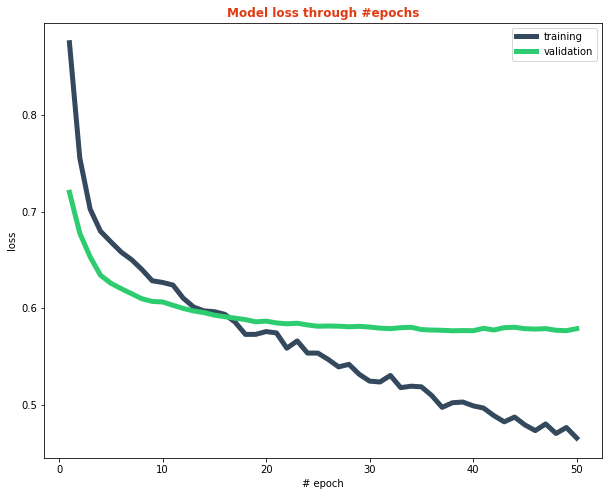

In [ ]:
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)

In [ ]:
score = clf.score(X_test, y_test)
print(score)

2/2 [==============================] - 0s 6ms/step - loss: 0.5871 - accuracy: 0.7964
0.7964134812355042


# CNN

In [ ]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf

In [ ]:
input_shape=(40,)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(24, activation='softmax'))

ValueError: ignored

In [ ]:
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [ ]:
history = CNNmodel.fit(X_train, y_train, epochs=20, validation_data= (X_test, y_test))

Epoch 1/20


ValueError: ignored

In [ ]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,21)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

# RNN + CNN

In [ ]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

NameError: ignored

In [ ]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [ ]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

NameError: ignored

# Gaussian Mixture Models

In [ ]:
import matplotlib as mpl

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.externals.six.moves import xrange
from sklearn import mixture

In [ ]:
Y_num = []

for label in tqdm(train_labels):
  if label[1] == 1:
    Y_num.append(2) #music
  elif label[0] == 1:
    Y_num.append(1) #speech
  else:
    Y_num.append(0) #silence

X = np.reshape(train_audios_mfcc, (train_audios_mfcc.shape[0], -1))
st = StandardScaler()
X = st.fit_transform(X)

Y = Y_num
print(np.shape(X), np.shape(Y))
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

100%|██████████| 4740/4740 [00:00<00:00, 640124.96it/s]

(4740, 40) (4740,)
(3792, 40) (948, 40) (3792,) (948,)


In [ ]:
n_classes = len(np.unique(y_train))

classifiers = dict((covar_type, 
                    mixture.GaussianMixture(n_components=n_classes,
                    covariance_type=covar_type,max_iter=200))
                   for covar_type in ['spherical', 'diag', 'tied', 'full'])

n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.means_ = np.array([X_train[y_train == i].mean(axis=0)
                                  for i in xrange(n_classes)])
    classifier.fit(X_train)

    y_train_pred = classifier.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == np.asarray(y_train).ravel()) * 100
    # train_accuracy = classifier.score(X_train, y_train)
    print('Train accuracy:', train_accuracy)

    y_test_pred = classifier.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == np.asarray(y_test).ravel()) * 100
    # test_accuracy = classifier.score(X_test, y_test)
    print('Test accuracy:', test_accuracy)

Train accuracy: 22.837552742616033
Test accuracy: 22.362869198312236
Train accuracy: 54.008438818565395
Test accuracy: 54.74683544303798
Train accuracy: 32.83227848101266
Test accuracy: 32.383966244725734
Train accuracy: 51.95147679324894
Test accuracy: 55.06329113924051


# Hidden Markov Models

In [ ]:
!pip install --upgrade --user hmmlearn

     |████████████████████████████████| 374 kB 4.3 MB/s 


In [ ]:
Y_num = []

for label in tqdm(train_labels):
  if label[1] == 1:
    Y_num.append(2) #music
  elif label[0] == 1:
    Y_num.append(1) #speech
  else:
    Y_num.append(0) #silence

X = np.reshape(train_audios_mfcc, (train_audios_mfcc.shape[0], -1))
st = StandardScaler()
X = st.fit_transform(X)

Y = Y_num
print(np.shape(X), np.shape(Y))
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state=42)

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

100%|██████████| 4740/4740 [00:00<00:00, 299124.35it/s]

(4740, 40) (4740,)
(3792, 40) (948, 40) (3792,) (948,)


In [ ]:
from hmmlearn import hmm

model = hmm.GaussianHMM(3, 'full')
# lengths = np.ones(np.shape(X_train)[0], dtype='int16')*np.shape(X_train)[1]
model.fit(X_train)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [ ]:
y_train_pred = model.predict(X_train)
train_accuracy = np.mean(y_train_pred.ravel() == np.asarray(y_train).ravel()) * 100
# train_accuracy = classifier.score(X_train, y_train)
print('Train accuracy:', train_accuracy)

y_test_pred = model.predict(X_test)
test_accuracy = np.mean(y_test_pred.ravel() == np.asarray(y_test).ravel()) * 100
# test_accuracy = classifier.score(X_test, y_test)
print('Test accuracy:', test_accuracy)

Train accuracy: 37.130801687763714
Test accuracy: 35.232067510548525


In [ ]:
print(model.get_params())

{'algorithm': 'viterbi', 'covariance_type': 'full', 'covars_prior': 0.01, 'covars_weight': 1, 'init_params': 'stmc', 'means_prior': 0, 'means_weight': 0, 'min_covar': 0.001, 'n_components': 3, 'n_iter': 10, 'params': 'stmc', 'random_state': None, 'startprob_prior': 1.0, 'tol': 0.01, 'transmat_prior': 1.0, 'verbose': False}
